# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Mentoría 16 - ¿Cómo identificar fuga de ventas? Inteligencia artificial aplicada al sector comercial.

### Explorando Patrones de Datos a través de Clustering (TP3)

#### Parte 4: Evaluación de resultados.

**Integrantes:**
- Canalis, Patricio.
- Chevallier-Boutell, Ignacio José.
- Villarroel Torrez, Daniel.

**Mentores:**
- Gonzalez, Lucía
- Lahoz, Nahuel

---
## Librerías

In [67]:
# Visualización y curación
import pandas as pd
import numpy as np
import seaborn as sns

# Clustering
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, mutual_info_score

# Funciones propias
from tp3_utils_cluster import *
%load_ext autoreload
%autoreload 2

# Preferencias
pd.set_option('display.float_format', None) 
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows',150)
sns.set_context('talk')
sns.set_theme(style='white')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
# Datasets

## Carga

Los datasets que necesitamos son:
* `original` >> dataset curado, previo al cálculo de variaciones porcentuales (punto 15). Cada renglón representa ventas para un mes, ID y Subrubro en particular.
* `pivoteado` >> dataset pivoteado completo. Cada renglón representa vendedores (combinaciones de ID y Subrubro).
* `sr10` >> dataset pivoteado con los 10 subrubros que quedaron, luego de imputar con KNN y hacer PCA de 12 componentes.
* `outliers` >> información sobre los outliers encontrados en cada subrubro mediante DBSCAN.

### `original`

De aquí vamos a obtener para cada vendedor:
* El promedio de ventas
* El promedio de comisiones
* La cantidad de meses en los cuales tiene datos faltantes

In [68]:
original = pd.read_csv('../data/interim/tp3_registros_vendedores_abs.csv').drop(columns=['Omega', 'Modelo']).copy()
original

,Subrubro,ID,Fecha,Ventas,Comision,Dato_original
0,Com. Varios,5,2019-01-01,0.00,0.00,0
1,Com. Varios,19,2019-01-01,0.00,0.00,0
2,Com. Varios,22,2019-01-01,0.00,0.00,0
3,Com. Varios,33,2019-01-01,0.00,0.00,0
4,Com. Varios,41,2019-01-01,0.00,0.00,1
...,...,...,...,...,...,...
193615,Venta Agrop.,3023,2022-06-01,3689910.44,110697.31,1
193616,Venta Agrop.,3041,2022-06-01,61730286.02,1851908.58,1
193617,Venta Agrop.,3056,2022-06-01,4279280.00,106982.00,1
193618,Venta Agrop.,3065,2022-06-01,822098.02,20552.45,1


In [69]:
original = original.groupby(['ID', 'Subrubro']).agg({'Ventas': 'mean', 'Comision': 'mean', 'Dato_original': 'sum'}).reset_index()
original['Faltantes'] = 42 - original['Dato_original']
original = original.drop(columns='Dato_original')
original = original.rename(columns={'Ventas': 'Abs_ven_mean', 'Comision': 'Abs_com_mean'})
original

,ID,Subrubro,Abs_ven_mean,Abs_com_mean,Faltantes
0,0,Miscelaneo,3.763450e+06,121799.704086,0
1,1,Miscelaneo,2.160555e+07,957021.242103,0
2,2,Miscelaneo,7.596405e+06,345909.071399,0
3,4,Gondola,1.287897e+07,584686.537123,0
4,5,Com. Varios,2.055571e+05,11940.285419,16
...,...,...,...,...,...
4605,3122,Miscelaneo,4.189080e+05,19898.127850,39
4606,3123,Com. Varios,1.422810e+03,0.000000,41
4607,3126,Gondola,8.636458e+05,43182.289074,36
4608,3127,Vehiculos,2.377502e+04,1129.313560,40


### `pivoteado`

De aquí vamos a obtener, para cada vendedor:
* Las 136 columnas con variaciones porcentuales de cada mes (para ventas/comisiones e intercuatrimestrales/interanuales)
* El promedio y varianza (para ventas/comisiones e intercuatrimestrales/interanuales)

In [70]:
pivoteado = pd.read_csv('../data/interim/tp3_vendedores_vector.csv').drop(columns=['Omega', 'Modelo']).copy()
pivoteado

,ID,Subrubro,F_pct_Com_1905,F_pct_Com_1906,F_pct_Com_1907,F_pct_Com_1908,F_pct_Com_1909,F_pct_Com_1910,F_pct_Com_1911,F_pct_Com_1912,F_pct_Com_2001,F_pct_Com_2002,F_pct_Com_2003,F_pct_Com_2004,F_pct_Com_2005,F_pct_Com_2006,F_pct_Com_2007,F_pct_Com_2008,F_pct_Com_2009,F_pct_Com_2010,F_pct_Com_2011,F_pct_Com_2012,F_pct_Com_2101,F_pct_Com_2102,F_pct_Com_2103,F_pct_Com_2104,F_pct_Com_2105,F_pct_Com_2106,F_pct_Com_2107,F_pct_Com_2108,F_pct_Com_2109,F_pct_Com_2110,F_pct_Com_2111,F_pct_Com_2112,F_pct_Com_2201,F_pct_Com_2202,F_pct_Com_2203,F_pct_Com_2204,F_pct_Com_2205,F_pct_Com_2206,F_pct_Ven_1905,F_pct_Ven_1906,F_pct_Ven_1907,F_pct_Ven_1908,F_pct_Ven_1909,F_pct_Ven_1910,F_pct_Ven_1911,F_pct_Ven_1912,F_pct_Ven_2001,F_pct_Ven_2002,F_pct_Ven_2003,F_pct_Ven_2004,F_pct_Ven_2005,F_pct_Ven_2006,F_pct_Ven_2007,F_pct_Ven_2008,F_pct_Ven_2009,F_pct_Ven_2010,F_pct_Ven_2011,F_pct_Ven_2012,F_pct_Ven_2101,F_pct_Ven_2102,F_pct_Ven_2103,F_pct_Ven_2104,F_pct_Ven_2105,F_pct_Ven_2106,F_pct_Ven_2107,F_pct_Ven_2108,F_pct_Ven_2109,F_pct_Ven_2110,F_pct_Ven_2111,F_pct_Ven_2112,F_pct_Ven_2201,F_pct_Ven_2202,F_pct_Ven_2203,F_pct_Ven_2204,F_pct_Ven_2205,F_pct_Ven_2206,Y_pct_Com_2001,Y_pct_Com_2002,Y_pct_Com_2003,Y_pct_Com_2004,Y_pct_Com_2005,Y_pct_Com_2006,Y_pct_Com_2007,Y_pct_Com_2008,Y_pct_Com_2009,Y_pct_Com_2010,Y_pct_Com_2011,Y_pct_Com_2012,Y_pct_Com_2101,Y_pct_Com_2102,Y_pct_Com_2103,Y_pct_Com_2104,Y_pct_Com_2105,Y_pct_Com_2106,Y_pct_Com_2107,Y_pct_Com_2108,Y_pct_Com_2109,Y_pct_Com_2110,Y_pct_Com_2111,Y_pct_Com_2112,Y_pct_Com_2201,Y_pct_Com_2202,Y_pct_Com_2203,Y_pct_Com_2204,Y_pct_Com_2205,Y_pct_Com_2206,Y_pct_Ven_2001,Y_pct_Ven_2002,Y_pct_Ven_2003,Y_pct_Ven_2004,Y_pct_Ven_2005,Y_pct_Ven_2006,Y_pct_Ven_2007,Y_pct_Ven_2008,Y_pct_Ven_2009,Y_pct_Ven_2010,Y_pct_Ven_2011,Y_pct_Ven_2012,Y_pct_Ven_2101,Y_pct_Ven_2102,Y_pct_Ven_2103,Y_pct_Ven_2104,Y_pct_Ven_2105,Y_pct_Ven_2106,Y_pct_Ven_2107,Y_pct_Ven_2108,Y_pct_Ven_2109,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206
0,0,Miscelaneo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.203215,-0.710101,-0.710101,-0.903021,-0.876897,-0.665474,-0.665474,0.000000,0.000000,0.000000,0.000000,0.000000,0.035706,1.598752,-0.147205,-0.147205,-0.011453,-0.661136,0.032632,-0.240964,0.580411,0.580411,0.580411,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,452.547408,457.728829,457.728829,457.728829,-0.203215,-0.710101,-0.710101,-0.938750,-0.922251,-0.788721,-0.788721,0.000000,0.000000,0.000000,-0.954996,-0.954996,0.035706,1.598752,17.949262,17.949262,-0.011453,-0.661136,0.032632,-0.240964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.901913,-0.903021,-0.903021,-0.903021,-0.872501,-0.130651,-0.714718,-0.147205,0.023844,-0.119376,-0.119376,-0.352698,0.580411,0.580411,0.580411,0.000000,0.000000,0.000000,452.547408,457.728829,457.728829,457.728829,360.379741,131.985243,131.985243,27.097036,27.097036,27.097036,27.097036,27.097036,-0.938050,-0.938750,-0.997244,-0.997244,-0.919475,-0.450937,-0.819822,-0.147205,0.023844,-0.119376,-0.119376,-0.352698
1,1,Miscelaneo,0.539416,0.646451,0.056943,-0.282992,-0.447945,-0.435162,-0.180079,1.212314,0.443643,0.412318,-0.397606,-0.610106,-0.915708,0.012316,0.887189,0.021014,5.516357,-0.546791,-0.374321,1.336717,0.165957,0.383341,0.514635,-0.320647,0.473654,0.494902,-0.136233,-0.266387,-0.202242,-0.349614,-0.031099,0.900433,-0.155532,0.495029,0.226926,-0.151318,1.188350,0.390497,0.560242,0.592999,0.011296,-0.266983,-0.441363,-0.430089,-0.167779,1.110347,0.185458,0.176078,-0.489700,-0.664758,-0.894072,0.009338,0.879161,0.026533,4.183454,-0.535172,-0.373324,1.276247,0.168231,0.334280,0.487384,-0.320647,0.452886,0.495895,-0.136233,-0.266387,-0.202242,-0.348981,-0.031099,0.900433,-0.155532,0.492585,0.227850,-0.151318,1.190775,0.390497,0.226868,0.313423,-0.477960,-0.381531,-0.932822,-0.192445,-0.067888,-0.119305,-0

In [71]:
# Calculando media y varianza para ventas intercuatrimestral
pivoteado['F_ven_mean'] = pivoteado.iloc[:, 2:40].mean(axis=1)
pivoteado['F_ven_var'] = pivoteado.iloc[:, 2:40].var(axis=1)

# Calculando media y varianza para comision intercuatrimestral
pivoteado['F_com_mean'] = pivoteado.iloc[:, 40:78].mean(axis=1)
pivoteado['F_com_var'] = pivoteado.iloc[:, 40:78].var(axis=1)

# Calculando media y varianza para ventas interanual
pivoteado['Y_ven_mean'] = pivoteado.iloc[:, 78:108].mean(axis=1)
pivoteado['Y_ven_var'] = pivoteado.iloc[:, 78:108].var(axis=1)

# Calculando media y varianza para comision interanual
pivoteado['Y_com_mean'] = pivoteado.iloc[:, 108:138].mean(axis=1)
pivoteado['Y_com_var'] = pivoteado.iloc[:, 108:138].var(axis=1)

pivoteado

,ID,Subrubro,F_pct_Com_1905,F_pct_Com_1906,F_pct_Com_1907,F_pct_Com_1908,F_pct_Com_1909,F_pct_Com_1910,F_pct_Com_1911,F_pct_Com_1912,F_pct_Com_2001,F_pct_Com_2002,F_pct_Com_2003,F_pct_Com_2004,F_pct_Com_2005,F_pct_Com_2006,F_pct_Com_2007,F_pct_Com_2008,F_pct_Com_2009,F_pct_Com_2010,F_pct_Com_2011,F_pct_Com_2012,F_pct_Com_2101,F_pct_Com_2102,F_pct_Com_2103,F_pct_Com_2104,F_pct_Com_2105,F_pct_Com_2106,F_pct_Com_2107,F_pct_Com_2108,F_pct_Com_2109,F_pct_Com_2110,F_pct_Com_2111,F_pct_Com_2112,F_pct_Com_2201,F_pct_Com_2202,F_pct_Com_2203,F_pct_Com_2204,F_pct_Com_2205,F_pct_Com_2206,F_pct_Ven_1905,F_pct_Ven_1906,F_pct_Ven_1907,F_pct_Ven_1908,F_pct_Ven_1909,F_pct_Ven_1910,F_pct_Ven_1911,F_pct_Ven_1912,F_pct_Ven_2001,F_pct_Ven_2002,F_pct_Ven_2003,F_pct_Ven_2004,F_pct_Ven_2005,F_pct_Ven_2006,F_pct_Ven_2007,F_pct_Ven_2008,F_pct_Ven_2009,F_pct_Ven_2010,F_pct_Ven_2011,F_pct_Ven_2012,F_pct_Ven_2101,F_pct_Ven_2102,F_pct_Ven_2103,F_pct_Ven_2104,F_pct_Ven_2105,F_pct_Ven_2106,F_pct_Ven_2107,F_pct_Ven_2108,F_pct_Ven_2109,F_pct_Ven_2110,F_pct_Ven_2111,F_pct_Ven_2112,F_pct_Ven_2201,F_pct_Ven_2202,F_pct_Ven_2203,F_pct_Ven_2204,F_pct_Ven_2205,F_pct_Ven_2206,Y_pct_Com_2001,Y_pct_Com_2002,Y_pct_Com_2003,Y_pct_Com_2004,Y_pct_Com_2005,Y_pct_Com_2006,Y_pct_Com_2007,Y_pct_Com_2008,Y_pct_Com_2009,Y_pct_Com_2010,Y_pct_Com_2011,Y_pct_Com_2012,Y_pct_Com_2101,Y_pct_Com_2102,Y_pct_Com_2103,Y_pct_Com_2104,Y_pct_Com_2105,Y_pct_Com_2106,Y_pct_Com_2107,Y_pct_Com_2108,Y_pct_Com_2109,Y_pct_Com_2110,Y_pct_Com_2111,Y_pct_Com_2112,Y_pct_Com_2201,Y_pct_Com_2202,Y_pct_Com_2203,Y_pct_Com_2204,Y_pct_Com_2205,Y_pct_Com_2206,Y_pct_Ven_2001,Y_pct_Ven_2002,Y_pct_Ven_2003,Y_pct_Ven_2004,Y_pct_Ven_2005,Y_pct_Ven_2006,Y_pct_Ven_2007,Y_pct_Ven_2008,Y_pct_Ven_2009,Y_pct_Ven_2010,Y_pct_Ven_2011,Y_pct_Ven_2012,Y_pct_Ven_2101,Y_pct_Ven_2102,Y_pct_Ven_2103,Y_pct_Ven_2104,Y_pct_Ven_2105,Y_pct_Ven_2106,Y_pct_Ven_2107,Y_pct_Ven_2108,Y_pct_Ven_2109,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206,F_ven_mean,F_ven_var,F_com_mean,F_com_var,Y_ven_mean,Y_ven_var,Y_com_mean,Y_com_var
0,0,Miscelaneo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.203215,-0.710101,-0.710101,-0.903021,-0.876897,-0.665474,-0.665474,0.000000,0.000000,0.000000,0.000000,0.000000,0.035706,1.598752,-0.147205,-0.147205,-0.011453,-0.661136,0.032632,-0.240964,0.580411,0.580411,0.580411,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,452.547408,457.728829,457.728829,457.728829,-0.203215,-0.710101,-0.710101,-0.938750,-0.922251,-0.788721,-0.788721,0.000000,0.000000,0.000000,-0.954996,-0.954996,0.035706,1.598752,17.949262,17.949262,-0.011453,-0.661136,0.032632,-0.240964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.901913,-0.903021,-0.903021,-0.903021,-0.872501,-0.130651,-0.714718,-0.147205,0.023844,-0.119376,-0.119376,-0.352698,0.580411,0.580411,0.580411,0.000000,0.000000,0.000000,452.547408,457.728829,457.728829,457.728829,360.379741,131.985243,131.985243,27.097036,27.097036,27.097036,27.097036,27.097036,-0.938050,-0.938750,-0.997244,-0.997244,-0.919475,-0.450937,-0.819822,-0.147205,0.023844,-0.119376,-0.119376,-0.352698,-0.213758,0.300159,48.872509,20087.476338,-0.503638,0.152751,86.017807,26888.481952
1,1,Miscelaneo,0.539416,0.646451,0.056943,-0.282992,-0.447945,-0.435162,-0.180079,1.212314,0.443643,0.412318,-0.397606,-0.610106,-0.915708,0.012316,0.887189,0.021014,5.516357,-0.546791,-0.374321,1.336717,0.165957,0.383341,0.514635,-0.320647,0.473654,0.494902,-0.136233,-0.266387,-0.202242,-0.349614,-0.031099,0.900433,-0.155532,0.495029,0.226926,-0.151318,1.188350,0.390497,0.560242,0.592999,0.011296,-0.266983,-0.441363,-0.430089,-0.167779,1.110347,0.185458,0.176078,-0.489700,-0.664758,-0.894072,0.009338,0.879161,0.026533,4.183454,-0.535172,-0.373324,1.276247,0.168231,0.334280,0.487384,-0.320647,0.452886,0.495895,-0.136233,-0.266387,-0.2022

### `sr10`

Este es el dataset al cual le traeremos variables de los otros datasets.

In [72]:
sr10 = pd.read_csv('../data/interim/tp3_sr10_knn5_pca12.csv').copy()
sr10

,ID,Subrubro,Modelo,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,47,Com. Varios,0,0.024157,0.085663,0.112791,0.638456,0.529641,0.177086,0.292179,0.169751,0.213063,0.054239,0.066772,0.048243
1,48,Com. Varios,0,0.024779,0.074898,0.100222,0.610905,0.529641,0.113269,0.295353,0.172279,0.154298,0.069687,0.022208,0.059349
2,53,Com. Varios,0,0.055998,0.085678,0.150325,0.621437,0.542959,0.119091,0.144486,0.053484,0.148443,0.056520,0.194009,0.105797
3,65,Com. Varios,0,0.018791,0.096209,0.140642,0.640455,0.568752,0.121955,0.183837,0.139717,0.125105,0.033843,0.050249,0.060159
4,66,Com. Varios,0,0.037439,0.139958,0.123521,0.617438,0.519357,0.100186,0.184210,0.220576,0.222917,0.045600,0.057636,0.056142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,2934,Venta Agrop.,0,0.308393,0.115711,0.083556,0.653290,0.021459,0.048518,0.200825,0.697719,0.030455,0.090136,0.183248,0.127074
3131,2946,Venta Agrop.,0,0.186802,0.121874,0.103454,0.652925,0.016151,0.018920,0.254912,0.699166,0.080256,0.119761,0.158124,0.152288
3132,2963,Venta Agrop.,0,0.168331,0.035004,0.064374,0.644257,0.015325,0.105637,0.256168,0.716854,0.127578,0.087880,0.144415,0.074492
3133,2968,Venta Agrop.,0,0.179929,0.011520,0.098092,0.633031,0.015494,0.170615,0.316114,0.746559,0.071796,0.116324,0.134548,0.067767


### `outliers`

In [73]:
outliers = pd.read_csv('../data/interim/tp3_outliers_dbscan.csv').drop(columns=['Modelo'])
outliers

,ID,Subrubro
0,141,Com. Varios
1,233,Com. Varios
2,324,Com. Varios
3,373,Com. Varios
4,735,Com. Varios
...,...,...
212,2147,Venta Agrop.
213,2605,Venta Agrop.
214,2661,Venta Agrop.
215,2716,Venta Agrop.


## Dataset final

En primer lugar, al dataset `sr10`, le traemos los `outliers`.

A `outliers` le agregamos una variable auxiliar llamada Cluster, con valor -1. Al mergearla con el resto de los datasets, luego se asignará valor 0 a los demás vendedores. Representando así a los 2 "clusters" resultantes del DBSCAN.

In [74]:
outliers['Cluster'] = -1

In [75]:
final = sr10.merge(outliers, on=['ID', 'Subrubro'], how='left')
final['Cluster'].fillna(0, inplace=True)
final['Cluster'] = final['Cluster'].astype(int)
final

,ID,Subrubro,Modelo,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,Cluster
0,47,Com. Varios,0,0.024157,0.085663,0.112791,0.638456,0.529641,0.177086,0.292179,0.169751,0.213063,0.054239,0.066772,0.048243,0
1,48,Com. Varios,0,0.024779,0.074898,0.100222,0.610905,0.529641,0.113269,0.295353,0.172279,0.154298,0.069687,0.022208,0.059349,0
2,53,Com. Varios,0,0.055998,0.085678,0.150325,0.621437,0.542959,0.119091,0.144486,0.053484,0.148443,0.056520,0.194009,0.105797,0
3,65,Com. Varios,0,0.018791,0.096209,0.140642,0.640455,0.568752,0.121955,0.183837,0.139717,0.125105,0.033843,0.050249,0.060159,0
4,66,Com. Varios,0,0.037439,0.139958,0.123521,0.617438,0.519357,0.100186,0.184210,0.220576,0.222917,0.045600,0.057636,0.056142,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,2934,Venta Agrop.,0,0.308393,0.115711,0.083556,0.653290,0.021459,0.048518,0.200825,0.697719,0.030455,0.090136,0.183248,0.127074,0
3131,2946,Venta Agrop.,0,0.186802,0.121874,0.103454,0.652925,0.016151,0.018920,0.254912,0.699166,0.080256,0.119761,0.158124,0.152288,0
3132,2963,Venta Agrop.,0,0.168331,0.035004,0.064374,0.644257,0.015325,0.105637,0.256168,0.716854,0.127578,0.087880,0.144415,0.074492,0
3133,2968,Venta Agrop.,0,0.179929,0.011520,0.098092,0.633031,0.015494,0.170615,0.316114,0.746559,0.071796,0.116324,0.134548,0.067767,0


Ahora, al dataframe `final`, le traeremos las variables del dataframe `original`

In [76]:
final = final.merge(original, on=['ID', 'Subrubro'], how='left')
final

,ID,Subrubro,Modelo,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,Cluster,Abs_ven_mean,Abs_com_mean,Faltantes
0,47,Com. Varios,0,0.024157,0.085663,0.112791,0.638456,0.529641,0.177086,0.292179,0.169751,0.213063,0.054239,0.066772,0.048243,0,2.165792e+06,1.146649e+05,0
1,48,Com. Varios,0,0.024779,0.074898,0.100222,0.610905,0.529641,0.113269,0.295353,0.172279,0.154298,0.069687,0.022208,0.059349,0,5.709301e+05,2.457009e+04,0
2,53,Com. Varios,0,0.055998,0.085678,0.150325,0.621437,0.542959,0.119091,0.144486,0.053484,0.148443,0.056520,0.194009,0.105797,0,9.367952e+06,5.925151e+05,0
3,65,Com. Varios,0,0.018791,0.096209,0.140642,0.640455,0.568752,0.121955,0.183837,0.139717,0.125105,0.033843,0.050249,0.060159,0,7.657310e+06,4.688761e+05,0
4,66,Com. Varios,0,0.037439,0.139958,0.123521,0.617438,0.519357,0.100186,0.184210,0.220576,0.222917,0.045600,0.057636,0.056142,0,1.200657e+07,7.486922e+05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,2934,Venta Agrop.,0,0.308393,0.115711,0.083556,0.653290,0.021459,0.048518,0.200825,0.697719,0.030455,0.090136,0.183248,0.127074,0,4.262820e+08,1.223934e+07,0
3131,2946,Venta Agrop.,0,0.186802,0.121874,0.103454,0.652925,0.016151,0.018920,0.254912,0.699166,0.080256,0.119761,0.158124,0.152288,0,4.445341e+07,1.084339e+06,0
3132,2963,Venta Agrop.,0,0.168331,0.035004,0.064374,0.644257,0.015325,0.105637,0.256168,0.716854,0.127578,0.087880,0.144415,0.074492,0,2.329506e+06,5.577800e+04,0
3133,2968,Venta Agrop.,0,0.179929,0.011520,0.098092,0.633031,0.015494,0.170615,0.316114,0.746559,0.071796,0.116324,0.134548,0.067767,0,1.214534e+07,3.350624e+05,0


Por último, al dataframe `final`, le traeremos las variables del dataframe `pivoteado`

In [77]:
final = final.merge(pivoteado, on=['ID', 'Subrubro'], how='left')
final

,ID,Subrubro,Modelo,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,Cluster,Abs_ven_mean,Abs_com_mean,Faltantes,F_pct_Com_1905,F_pct_Com_1906,F_pct_Com_1907,F_pct_Com_1908,F_pct_Com_1909,F_pct_Com_1910,F_pct_Com_1911,F_pct_Com_1912,F_pct_Com_2001,F_pct_Com_2002,F_pct_Com_2003,F_pct_Com_2004,F_pct_Com_2005,F_pct_Com_2006,F_pct_Com_2007,F_pct_Com_2008,F_pct_Com_2009,F_pct_Com_2010,F_pct_Com_2011,F_pct_Com_2012,F_pct_Com_2101,F_pct_Com_2102,F_pct_Com_2103,F_pct_Com_2104,F_pct_Com_2105,F_pct_Com_2106,F_pct_Com_2107,F_pct_Com_2108,F_pct_Com_2109,F_pct_Com_2110,F_pct_Com_2111,F_pct_Com_2112,F_pct_Com_2201,F_pct_Com_2202,F_pct_Com_2203,F_pct_Com_2204,F_pct_Com_2205,F_pct_Com_2206,F_pct_Ven_1905,F_pct_Ven_1906,F_pct_Ven_1907,F_pct_Ven_1908,F_pct_Ven_1909,F_pct_Ven_1910,F_pct_Ven_1911,F_pct_Ven_1912,F_pct_Ven_2001,F_pct_Ven_2002,F_pct_Ven_2003,F_pct_Ven_2004,F_pct_Ven_2005,F_pct_Ven_2006,F_pct_Ven_2007,F_pct_Ven_2008,F_pct_Ven_2009,F_pct_Ven_2010,...,F_pct_Ven_2112,F_pct_Ven_2201,F_pct_Ven_2202,F_pct_Ven_2203,F_pct_Ven_2204,F_pct_Ven_2205,F_pct_Ven_2206,Y_pct_Com_2001,Y_pct_Com_2002,Y_pct_Com_2003,Y_pct_Com_2004,Y_pct_Com_2005,Y_pct_Com_2006,Y_pct_Com_2007,Y_pct_Com_2008,Y_pct_Com_2009,Y_pct_Com_2010,Y_pct_Com_2011,Y_pct_Com_2012,Y_pct_Com_2101,Y_pct_Com_2102,Y_pct_Com_2103,Y_pct_Com_2104,Y_pct_Com_2105,Y_pct_Com_2106,Y_pct_Com_2107,Y_pct_Com_2108,Y_pct_Com_2109,Y_pct_Com_2110,Y_pct_Com_2111,Y_pct_Com_2112,Y_pct_Com_2201,Y_pct_Com_2202,Y_pct_Com_2203,Y_pct_Com_2204,Y_pct_Com_2205,Y_pct_Com_2206,Y_pct_Ven_2001,Y_pct_Ven_2002,Y_pct_Ven_2003,Y_pct_Ven_2004,Y_pct_Ven_2005,Y_pct_Ven_2006,Y_pct_Ven_2007,Y_pct_Ven_2008,Y_pct_Ven_2009,Y_pct_Ven_2010,Y_pct_Ven_2011,Y_pct_Ven_2012,Y_pct_Ven_2101,Y_pct_Ven_2102,Y_pct_Ven_2103,Y_pct_Ven_2104,Y_pct_Ven_2105,Y_pct_Ven_2106,Y_pct_Ven_2107,Y_pct_Ven_2108,Y_pct_Ven_2109,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206,F_ven_mean,F_ven_var,F_com_mean,F_com_var,Y_ven_mean,Y_ven_var,Y_com_mean,Y_com_var
0,47,Com. Varios,0,0.024157,0.085663,0.112791,0.638456,0.529641,0.177086,0.292179,0.169751,0.213063,0.054239,0.066772,0.048243,0,2.165792e+06,1.146649e+05,0,NaN,0.361775,0.361775,0.361775,0.000000,1.240845,1.240845,1.240845,1.240845,-0.219782,-0.219782,-0.786799,-0.786799,0.601332,-0.344414,1.399140,1.114460,0.287679,0.448580,-0.558344,2.007878,-0.157161,3.723425,0.549622,1.045381,-0.452151,-0.909191,6.609853,-0.666078,2.422140,7.166483,0.736487,-0.476933,-0.186182,-0.755602,-0.608519,0.941509,-0.901532,4.351189,-0.457430,0.027849,-0.347237,-0.795220,4.624200,0.427676,0.427676,0.427676,-0.347454,4.001570,0.366722,-0.283651,0.601332,-0.344414,-0.795092,3.034176,0.287679,...,0.736487,-0.476933,-0.186182,-0.755602,-0.608519,0.941509,-0.901532,NaN,1.380856,1.380856,-0.349410,-0.522249,1.799686,0.146192,0.146192,0.010186,0.608811,-0.259051,-0.774093,0.355969,0.737935,3.485688,0.641970,12.008699,-0.405417,-0.378663,4.208178,1.054375,0.580167,2.502833,19.477347,-0.642746,0.525758,-0.818758,4.173187,-0.660889,-0.725767,0.564469,0.991261,6.339481,0.273695,-0.790569,4.876968,3.681291,-0.600177,3.125813,0.345551,3.749835,0.448170,7.692404,-0.938422,3.485688,0.641971,23.819281,-0.405416,-0.378663,59.979447,1.054375,0.580167,2.502832,19.477350,-0.642746,42.061670,-0.818758,4.173187,-0.660889,-0.725767,0.731714,3.263942,1.421514,9.308156,1.713374,18.059657,6.130117,185.870048
1,48,Com. Varios,0,0.024779,0.074898,0.100222,0.610905,0.529641,0.113269,0.295353,0.172279,0.154298,0.069687,0.022208,0.059349,0,5.709301e+05,2.457009e+04,0,NaN,0.004972,-0.288407,-0.288407,0.000000,-0.246350,1.279878,1.279878,0.309222,-0.005099,-0.708467,-0.526067,-0.528717,-0.042017,0.023123,-0.370641,0.114882,-0.078522,0.412962,0.412962,-0.054152,-0.035785,-0.450869,-0.404847,-0.138851,-0.035639,0.204843,0.157658,0.152194,-0.041060,0.006502,-0.046134,-0.030447,-0.138678,-0.113053,-0.043209,-0.208730,0.038563,1.055873,-0.445328,-0.579541,0.101357,-0.288111,0.

Queda un dataset con 163 columnas, vamos a definir grupos, para hacer más fácil el trabajo posterior:

In [78]:
Basics = ['ID', 'Subrubro', 'Modelo', 'Cluster']

PCA = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12']

Abs_summary = ['Abs_ven_mean', 'Abs_com_mean', 'Faltantes']

F_Com = ['F_pct_Com_1905', 'F_pct_Com_1906', 'F_pct_Com_1907', 'F_pct_Com_1908', 'F_pct_Com_1909',
        'F_pct_Com_1910', 'F_pct_Com_1911', 'F_pct_Com_1912', 'F_pct_Com_2001', 'F_pct_Com_2002',
        'F_pct_Com_2003', 'F_pct_Com_2004', 'F_pct_Com_2005', 'F_pct_Com_2006', 'F_pct_Com_2007',
        'F_pct_Com_2008', 'F_pct_Com_2009', 'F_pct_Com_2010', 'F_pct_Com_2011', 'F_pct_Com_2012',
        'F_pct_Com_2101', 'F_pct_Com_2102', 'F_pct_Com_2103', 'F_pct_Com_2104', 'F_pct_Com_2105',
        'F_pct_Com_2106', 'F_pct_Com_2107', 'F_pct_Com_2108', 'F_pct_Com_2109', 'F_pct_Com_2110',
        'F_pct_Com_2111', 'F_pct_Com_2112', 'F_pct_Com_2201', 'F_pct_Com_2202', 'F_pct_Com_2203',
        'F_pct_Com_2204', 'F_pct_Com_2205', 'F_pct_Com_2206']

F_Ven = ['F_pct_Ven_1905', 'F_pct_Ven_1906', 'F_pct_Ven_1907', 'F_pct_Ven_1908', 'F_pct_Ven_1909',
        'F_pct_Ven_1910', 'F_pct_Ven_1911', 'F_pct_Ven_1912', 'F_pct_Ven_2001', 'F_pct_Ven_2002',
        'F_pct_Ven_2003', 'F_pct_Ven_2004', 'F_pct_Ven_2005', 'F_pct_Ven_2006', 'F_pct_Ven_2007',
        'F_pct_Ven_2008', 'F_pct_Ven_2009', 'F_pct_Ven_2010', 'F_pct_Ven_2011', 'F_pct_Ven_2012',
        'F_pct_Ven_2101', 'F_pct_Ven_2102', 'F_pct_Ven_2103', 'F_pct_Ven_2104', 'F_pct_Ven_2105',
        'F_pct_Ven_2106', 'F_pct_Ven_2107', 'F_pct_Ven_2108', 'F_pct_Ven_2109', 'F_pct_Ven_2110',
        'F_pct_Ven_2111', 'F_pct_Ven_2112', 'F_pct_Ven_2201', 'F_pct_Ven_2202', 'F_pct_Ven_2203',
        'F_pct_Ven_2204', 'F_pct_Ven_2205', 'F_pct_Ven_2206']

Y_Com = ['Y_pct_Com_2001', 'Y_pct_Com_2002', 'Y_pct_Com_2003', 'Y_pct_Com_2004', 'Y_pct_Com_2005',
        'Y_pct_Com_2006', 'Y_pct_Com_2007', 'Y_pct_Com_2008', 'Y_pct_Com_2009', 'Y_pct_Com_2010',
        'Y_pct_Com_2011', 'Y_pct_Com_2012', 'Y_pct_Com_2101', 'Y_pct_Com_2102', 'Y_pct_Com_2103',
        'Y_pct_Com_2104', 'Y_pct_Com_2105', 'Y_pct_Com_2106', 'Y_pct_Com_2107', 'Y_pct_Com_2108',
        'Y_pct_Com_2109', 'Y_pct_Com_2110', 'Y_pct_Com_2111', 'Y_pct_Com_2112', 'Y_pct_Com_2201',
        'Y_pct_Com_2202', 'Y_pct_Com_2203', 'Y_pct_Com_2204', 'Y_pct_Com_2205', 'Y_pct_Com_2206']

Y_Ven = ['Y_pct_Ven_2001', 'Y_pct_Ven_2002', 'Y_pct_Ven_2003', 'Y_pct_Ven_2004', 'Y_pct_Ven_2005',
        'Y_pct_Ven_2006', 'Y_pct_Ven_2007', 'Y_pct_Ven_2008', 'Y_pct_Ven_2009', 'Y_pct_Ven_2010',
        'Y_pct_Ven_2011', 'Y_pct_Ven_2012', 'Y_pct_Ven_2101', 'Y_pct_Ven_2102', 'Y_pct_Ven_2103',
        'Y_pct_Ven_2104', 'Y_pct_Ven_2105', 'Y_pct_Ven_2106', 'Y_pct_Ven_2107', 'Y_pct_Ven_2108',
        'Y_pct_Ven_2109', 'Y_pct_Ven_2110', 'Y_pct_Ven_2111', 'Y_pct_Ven_2112', 'Y_pct_Ven_2201',
        'Y_pct_Ven_2202', 'Y_pct_Ven_2203', 'Y_pct_Ven_2204', 'Y_pct_Ven_2205', 'Y_pct_Ven_2206']

Pct_summary = ['F_ven_mean', 'F_ven_var', 'F_com_mean', 'F_com_var',
               'Y_ven_mean', 'Y_ven_var', 'Y_com_mean', 'Y_com_var']

Sabemos que de todos los subrubros, sólo vamos a poder responder a 9 de ellos (descontando `Tabaco`). Estos son:
* `Com. Varios`
* `Comb.`
* `Comb. Ley`
* `Farmacia`
* `Gondola`
* `Miscelaneo`
* `Supermercados`
* `Vehiculos`
* `Venta Agrop.`

Vamos a conservar solo estos subrubros:

In [79]:
subrubros_deseados = ['Com. Varios', 'Comb.', 'Comb. Ley', 'Farmacia', 'Gondola', 'Miscelaneo', 'Supermercados', 'Vehiculos', 'Venta Agrop.']
final = final[final['Subrubro'].isin(subrubros_deseados)].copy()
final

,ID,Subrubro,Modelo,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,Cluster,Abs_ven_mean,Abs_com_mean,Faltantes,F_pct_Com_1905,F_pct_Com_1906,F_pct_Com_1907,F_pct_Com_1908,F_pct_Com_1909,F_pct_Com_1910,F_pct_Com_1911,F_pct_Com_1912,F_pct_Com_2001,F_pct_Com_2002,F_pct_Com_2003,F_pct_Com_2004,F_pct_Com_2005,F_pct_Com_2006,F_pct_Com_2007,F_pct_Com_2008,F_pct_Com_2009,F_pct_Com_2010,F_pct_Com_2011,F_pct_Com_2012,F_pct_Com_2101,F_pct_Com_2102,F_pct_Com_2103,F_pct_Com_2104,F_pct_Com_2105,F_pct_Com_2106,F_pct_Com_2107,F_pct_Com_2108,F_pct_Com_2109,F_pct_Com_2110,F_pct_Com_2111,F_pct_Com_2112,F_pct_Com_2201,F_pct_Com_2202,F_pct_Com_2203,F_pct_Com_2204,F_pct_Com_2205,F_pct_Com_2206,F_pct_Ven_1905,F_pct_Ven_1906,F_pct_Ven_1907,F_pct_Ven_1908,F_pct_Ven_1909,F_pct_Ven_1910,F_pct_Ven_1911,F_pct_Ven_1912,F_pct_Ven_2001,F_pct_Ven_2002,F_pct_Ven_2003,F_pct_Ven_2004,F_pct_Ven_2005,F_pct_Ven_2006,F_pct_Ven_2007,F_pct_Ven_2008,F_pct_Ven_2009,F_pct_Ven_2010,...,F_pct_Ven_2112,F_pct_Ven_2201,F_pct_Ven_2202,F_pct_Ven_2203,F_pct_Ven_2204,F_pct_Ven_2205,F_pct_Ven_2206,Y_pct_Com_2001,Y_pct_Com_2002,Y_pct_Com_2003,Y_pct_Com_2004,Y_pct_Com_2005,Y_pct_Com_2006,Y_pct_Com_2007,Y_pct_Com_2008,Y_pct_Com_2009,Y_pct_Com_2010,Y_pct_Com_2011,Y_pct_Com_2012,Y_pct_Com_2101,Y_pct_Com_2102,Y_pct_Com_2103,Y_pct_Com_2104,Y_pct_Com_2105,Y_pct_Com_2106,Y_pct_Com_2107,Y_pct_Com_2108,Y_pct_Com_2109,Y_pct_Com_2110,Y_pct_Com_2111,Y_pct_Com_2112,Y_pct_Com_2201,Y_pct_Com_2202,Y_pct_Com_2203,Y_pct_Com_2204,Y_pct_Com_2205,Y_pct_Com_2206,Y_pct_Ven_2001,Y_pct_Ven_2002,Y_pct_Ven_2003,Y_pct_Ven_2004,Y_pct_Ven_2005,Y_pct_Ven_2006,Y_pct_Ven_2007,Y_pct_Ven_2008,Y_pct_Ven_2009,Y_pct_Ven_2010,Y_pct_Ven_2011,Y_pct_Ven_2012,Y_pct_Ven_2101,Y_pct_Ven_2102,Y_pct_Ven_2103,Y_pct_Ven_2104,Y_pct_Ven_2105,Y_pct_Ven_2106,Y_pct_Ven_2107,Y_pct_Ven_2108,Y_pct_Ven_2109,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206,F_ven_mean,F_ven_var,F_com_mean,F_com_var,Y_ven_mean,Y_ven_var,Y_com_mean,Y_com_var
0,47,Com. Varios,0,0.024157,0.085663,0.112791,0.638456,0.529641,0.177086,0.292179,0.169751,0.213063,0.054239,0.066772,0.048243,0,2.165792e+06,1.146649e+05,0,NaN,0.361775,0.361775,0.361775,0.000000,1.240845,1.240845,1.240845,1.240845,-0.219782,-0.219782,-0.786799,-0.786799,0.601332,-0.344414,1.399140,1.114460,0.287679,0.448580,-0.558344,2.007878,-0.157161,3.723425,0.549622,1.045381,-0.452151,-0.909191,6.609853,-0.666078,2.422140,7.166483,0.736487,-0.476933,-0.186182,-0.755602,-0.608519,0.941509,-0.901532,4.351189,-0.457430,0.027849,-0.347237,-0.795220,4.624200,0.427676,0.427676,0.427676,-0.347454,4.001570,0.366722,-0.283651,0.601332,-0.344414,-0.795092,3.034176,0.287679,...,0.736487,-0.476933,-0.186182,-0.755602,-0.608519,0.941509,-0.901532,NaN,1.380856,1.380856,-0.349410,-0.522249,1.799686,0.146192,0.146192,0.010186,0.608811,-0.259051,-0.774093,0.355969,0.737935,3.485688,0.641970,12.008699,-0.405417,-0.378663,4.208178,1.054375,0.580167,2.502833,19.477347,-0.642746,0.525758,-0.818758,4.173187,-0.660889,-0.725767,0.564469,0.991261,6.339481,0.273695,-0.790569,4.876968,3.681291,-0.600177,3.125813,0.345551,3.749835,0.448170,7.692404,-0.938422,3.485688,0.641971,23.819281,-0.405416,-0.378663,59.979447,1.054375,0.580167,2.502832,19.477350,-0.642746,42.061670,-0.818758,4.173187,-0.660889,-0.725767,0.731714,3.263942,1.421514,9.308156,1.713374,18.059657,6.130117,185.870048
1,48,Com. Varios,0,0.024779,0.074898,0.100222,0.610905,0.529641,0.113269,0.295353,0.172279,0.154298,0.069687,0.022208,0.059349,0,5.709301e+05,2.457009e+04,0,NaN,0.004972,-0.288407,-0.288407,0.000000,-0.246350,1.279878,1.279878,0.309222,-0.005099,-0.708467,-0.526067,-0.528717,-0.042017,0.023123,-0.370641,0.114882,-0.078522,0.412962,0.412962,-0.054152,-0.035785,-0.450869,-0.404847,-0.138851,-0.035639,0.204843,0.157658,0.152194,-0.041060,0.006502,-0.046134,-0.030447,-0.138678,-0.113053,-0.043209,-0.208730,0.038563,1.055873,-0.445328,-0.579541,0.101357,-0.288111,0.

---
# Evaluación de los clusters (sin clases)

Nos preguntamos qué características distintivas tienen los dos clusters resultantes.

## Varianzas sobre variaciones porcentuales

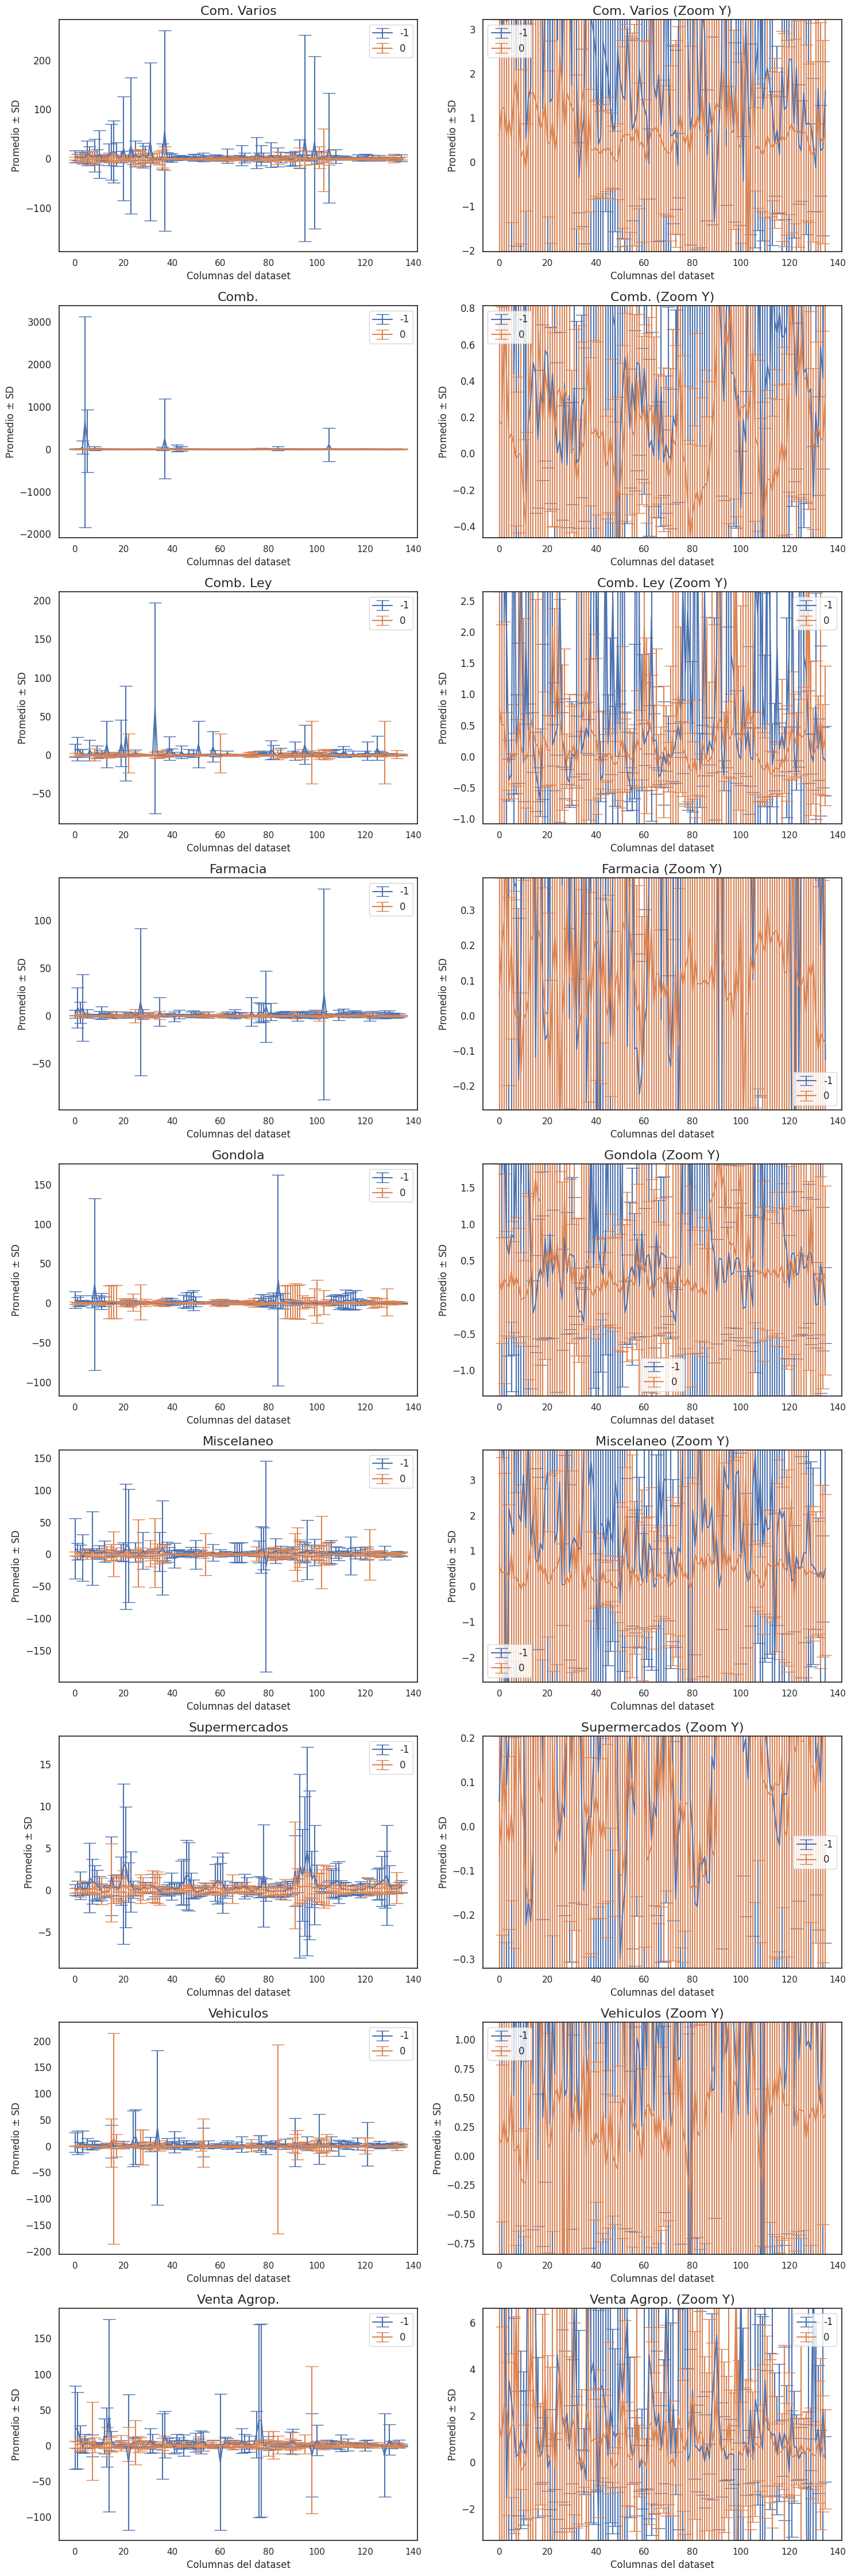

In [80]:
subrubros = final.Subrubro.unique()

num_subplots = len(subrubros)

fig, axs = plt.subplots(num_subplots, 2, figsize=(15, 5 * num_subplots))

for i, sr in enumerate(subrubros):

    menos_uno = final[(final['Subrubro'] == sr) & (final['Cluster'] == -1)][F_Ven + F_Com + Y_Ven + Y_Com].copy()
    cero = final[(final['Subrubro'] == sr) & (final['Cluster'] == 0)][F_Ven + F_Com + Y_Ven + Y_Com].copy()

    axs[i, 0].errorbar(range(len(menos_uno.mean())), menos_uno.mean(), yerr=menos_uno.std(), capsize=8, label='-1')
    axs[i, 0].errorbar(range(len(cero.mean())), cero.mean(), yerr=cero.std(), capsize=8, label='0')

    axs[i, 0].set_title(sr, fontsize=16)
    axs[i, 0].set_ylabel(r'Promedio $\pm$ SD', fontsize=12)
    axs[i, 0].tick_params(axis='y', labelsize=12)
    axs[i, 0].legend(fontsize=12)
    axs[i, 0].set_xlabel('Columnas del dataset', fontsize=12)

    y_mean = cero.mean()
    y_std = cero.std()
    y_min = (y_mean - y_std).iloc[0]
    y_max = (y_mean + y_std).iloc[0]

    axs[i, 1].errorbar(range(len(menos_uno.mean())), menos_uno.mean(), yerr=menos_uno.std(), capsize=8, label='-1')
    axs[i, 1].errorbar(range(len(cero.mean())), cero.mean(), yerr=cero.std(), capsize=8, label='0')

    axs[i, 1].set_title(sr + ' (Zoom Y)', fontsize=16)
    axs[i, 1].set_ylabel(r'Promedio $\pm$ SD', fontsize=12)
    axs[i, 1].tick_params(axis='y', labelsize=12)
    axs[i, 1].legend(fontsize=12)
    axs[i, 1].set_xlabel('Columnas del dataset', fontsize=12)
    
    axs[i, 1].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

En una primera aproximación, se observa que la distribución del cluster 0 tiene menos variabilidad que el cluster -1 (que contenía a los outliers del DBSCAN).

Vehículos tiene algunos meses que quedan fuera de la norma, pero en términos generales, también respeta lo anterior.

## Medias sobre variaciones porcentuales

Observando solo las medias de cada variable:

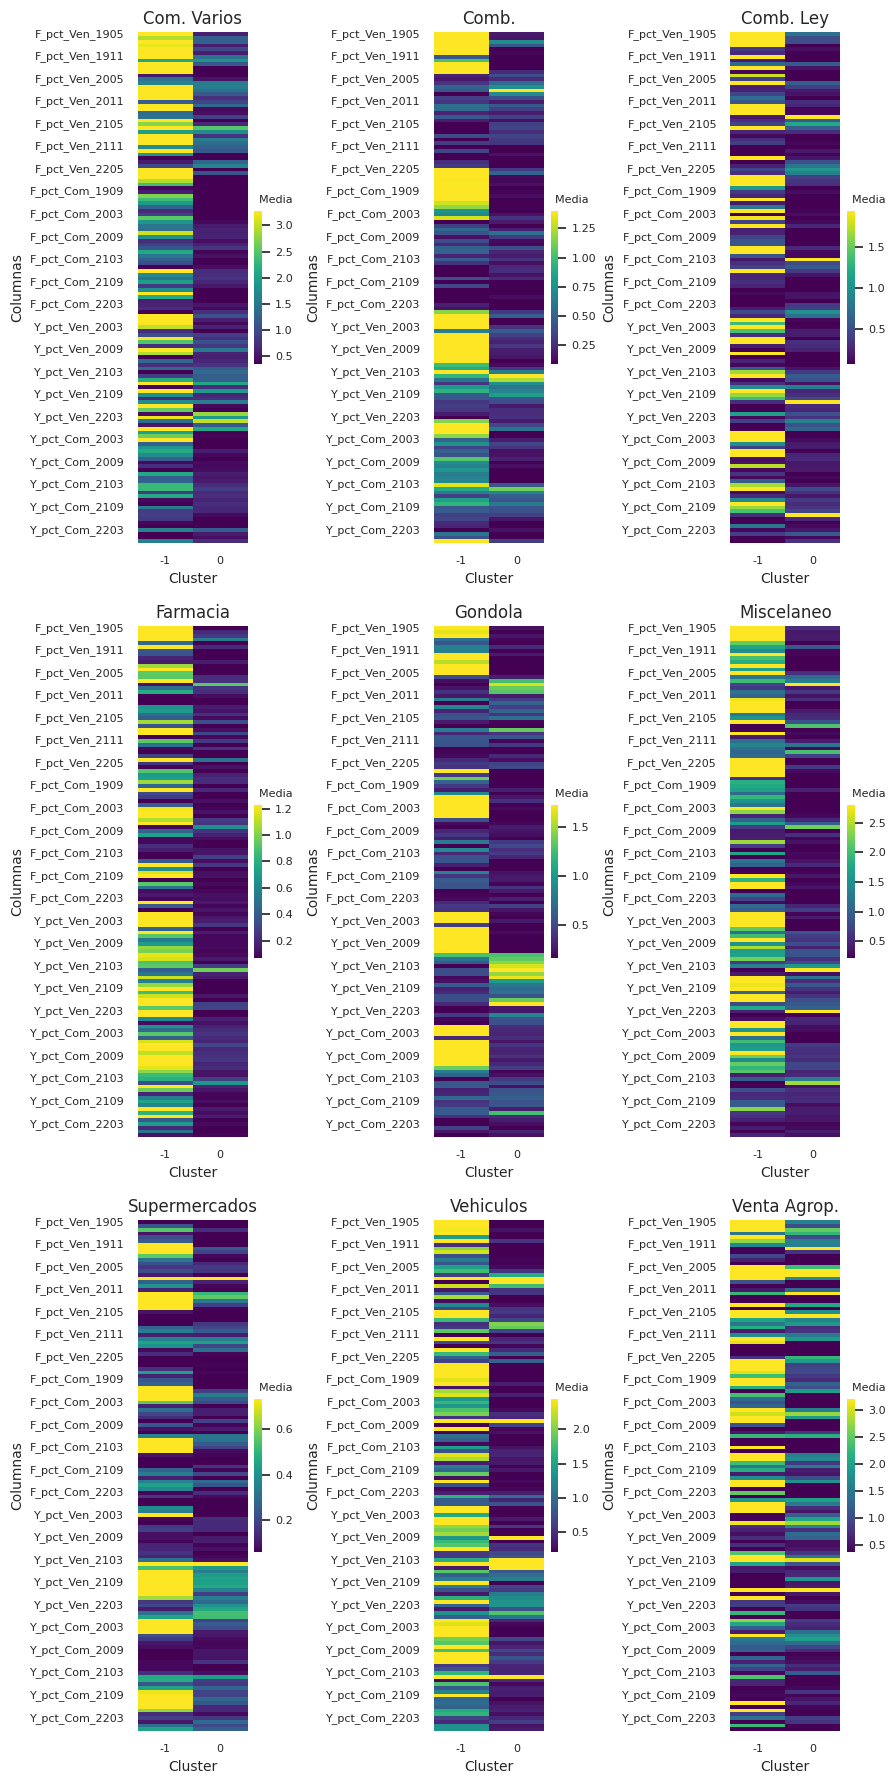

In [81]:
subrubros = final['Subrubro'].unique()
num_filas = 3
num_col = 3
fig, axes = plt.subplots(num_filas, num_col, figsize=(9, 18))

for i, subrubro in enumerate(subrubros):
    row = i // num_col
    col = i % num_col
    data_subset = final[final['Subrubro'] == subrubro]
    media_por_cluster = data_subset.groupby('Cluster')[F_Ven + F_Com + Y_Ven + Y_Com].mean().reset_index()
    media_por_cluster_transpuesto = media_por_cluster.set_index('Cluster').T
    media_por_cluster_transpuesto[-1] = media_por_cluster_transpuesto[-1].abs()
    media_por_cluster_transpuesto[0] = media_por_cluster_transpuesto[0].abs()
    vmin = min(np.percentile(media_por_cluster_transpuesto[-1], 25), np.percentile(media_por_cluster_transpuesto[0], 25))
    vmax = max(np.percentile(media_por_cluster_transpuesto[-1], 75), np.percentile(media_por_cluster_transpuesto[0], 75))
    heatmap = sns.heatmap(
        media_por_cluster_transpuesto,
        cmap='viridis',
        annot=False,
        fmt=".2f",
        cbar=True,
        vmin=vmin,
        vmax=vmax,
        ax=axes[row, col],
        cbar_kws={'shrink': 0.3}
    )
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=8)
    cbar.ax.set_title('          Media', fontsize=8)
    axes[row, col].tick_params(axis='both', labelsize=8)
    axes[row, col].set_title(f'{subrubro}')
    axes[row, col].set_xlabel('Cluster', fontsize=10)
    axes[row, col].set_ylabel('Columnas', fontsize=10)

for i in range(len(subrubros), num_filas * num_col):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

Comentarios:
* Se observa que para la mayoría de las variables, el cluster -1 tiene valores más altos de media (es decir, son variaciones porcentuales más altas) que el cluster 0. 
* Evidentemente, el cluster -1 contiene a los potenciales casos de fraude. 
* Mientras que el cluster 0 serían los vendedores con comportamiento normal.

## Efecto de los datos faltantes

Ahora veamos si la presencia de datos faltantes en el dataset original puede estar relacionada a casos fraudulentos:

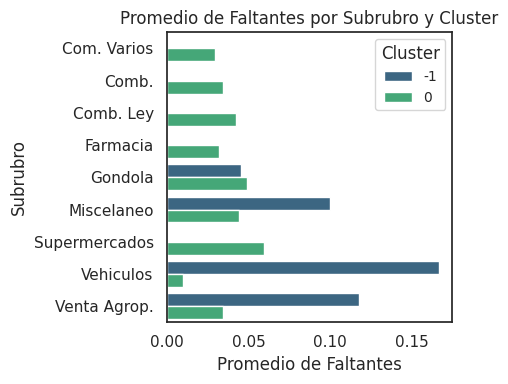

In [82]:
# Crear un gráfico de barras horizontales
plt.figure(figsize=(5, 4))
sns.barplot(x='Faltantes', y='Subrubro', hue='Cluster', data=final, orient='h', palette='viridis', errorbar=None)
plt.title('Promedio de Faltantes por Subrubro y Cluster')
plt.xlabel('Promedio de Faltantes')
plt.ylabel('Subrubro')
plt.legend(title='Cluster', title_fontsize='12', fontsize='10', loc='upper right')
plt.tight_layout()
plt.show()

No existe un patrón claro de faltantes entre los clusters. 

En algunos subrubros (Miscelaneo, Vehiculos y Venta Agrop.) hay más faltantes en el cluster -1. 

Mientras que en el resto de los subrubros, la mayoría de faltantes ocurren en el cluster 0.

---
# Evaluación de los clusters (con clases)

In [83]:
for subrubro in final["Subrubro"].unique():
    print(subrubro)
    subrubro_df = final[final['Subrubro'] == subrubro].copy()
    crosstab_table = pd.crosstab(subrubro_df['Modelo'], subrubro_df['Cluster'])
    display(crosstab_table)

Com. Varios


Cluster,-1,0
Modelo,,
0,29,268
1,0,4


Comb.


Cluster,-1,0
Modelo,,
0,15,168
1,0,6


Comb. Ley


Cluster,-1,0
Modelo,,
0,5,187
1,0,3


Farmacia


Cluster,-1,0
Modelo,,
0,16,153
1,0,4


Gondola


Cluster,-1,0
Modelo,,
0,22,384
1,0,3


Miscelaneo


Cluster,-1,0
Modelo,,
0,70,1150
1,0,20


Supermercados


Cluster,-1,0
Modelo,,
0,18,116
1,0,2


Vehiculos


Cluster,-1,0
Modelo,,
0,18,202
1,0,1


Venta Agrop.


Cluster,-1,0
Modelo,,
0,17,231
1,0,1


Observamos que para el total de los subrubros, los vendedores `Modelo` caen en el `Cluster 0`. Sin embargo, los `No Modelo` caen en ambos clusters. Lo cual tiene sentido, ya que el etiquetado de la variable Modelo no se hizo de manera exhaustiva sobre todos los vendedores, sino sobre una muestra.

## Algunas métricas

### Homogeneidad: cada cluster contiene sólo miembros de una clase

In [84]:
for subrubro in final["Subrubro"].unique():
    subrubro_df = final[final['Subrubro'] == subrubro].copy()
    homogeneidad = homogeneity_score(subrubro_df['Modelo'], subrubro_df['Cluster'])
    print(f'{subrubro}:', round(homogeneidad,2))

Com. Varios: 0.02
Comb.: 0.02
Comb. Ley: 0.01
Farmacia: 0.02
Gondola: 0.01
Miscelaneo: 0.01
Supermercados: 0.03
Vehiculos: 0.01


Venta Agrop.: 0.01


No se cumple, ya que el `Cluster 0` alberga `Modelos` y `No Modelos`

### Completitud: todos los miembros de una clase están en el mismo cluster

In [85]:
for subrubro in final["Subrubro"].unique():
    subrubro_df = final[final['Subrubro'] == subrubro].copy()
    completitud = completeness_score(subrubro_df['Modelo'], subrubro_df['Cluster'])
    print(f'{subrubro}:', round(completitud,2))

Com. Varios: 0.0
Comb.: 0.01
Comb. Ley: 0.0
Farmacia: 0.01
Gondola: 0.0
Miscelaneo: 0.0
Supermercados: 0.01
Vehiculos: 0.0
Venta Agrop.: 0.0


Tampoco se cumple, ya que los `No Modelos` pertenecen tanto al `Cluster -1` como al `Cluster 0`

### V-measure: media armónica de los anteriores

In [86]:
for subrubro in final["Subrubro"].unique():
    subrubro_df = final[final['Subrubro'] == subrubro].copy()
    v_measure = v_measure_score(subrubro_df['Modelo'], subrubro_df['Cluster'])
    print(f'{subrubro}:', round(v_measure,2))

Com. Varios: 0.01
Comb.: 0.01
Comb. Ley: 0.0
Farmacia: 0.01
Gondola: 0.0
Miscelaneo: 0.01
Supermercados: 0.01
Vehiculos: 0.0
Venta Agrop.: 0.0


### Adjusted Rand index: semejanza entre las etiquetas originales y las asignadas

In [87]:
for subrubro in final["Subrubro"].unique():
    subrubro_df = final[final['Subrubro'] == subrubro].copy()
    ari = adjusted_rand_score(subrubro_df['Modelo'], subrubro_df['Cluster'])
    print(f'{subrubro}:', round(ari,2))

Com. Varios: -0.02
Comb.: -0.04
Comb. Ley: -0.02
Farmacia: -0.03
Gondola: -0.01
Miscelaneo: -0.02
Supermercados: -0.02
Vehiculos: -0.01
Venta Agrop.: -0.01


### Información Mutua entre etiquetas originales y asignadas

In [88]:
for subrubro in final["Subrubro"].unique():
    subrubro_df = final[final['Subrubro'] == subrubro].copy()
    mutual_info = mutual_info_score(subrubro_df['Modelo'], subrubro_df['Cluster'])
    print(f'{subrubro}:', round(mutual_info,3))


Com. Varios: 0.001
Comb.: 0.003
Comb. Ley: 0.0
Farmacia: 0.002
Gondola: 0.0
Miscelaneo: 0.001
Supermercados: 0.002
Vehiculos: 0.0
Venta Agrop.: 0.0


El hecho de que todas las métricas hayan dado cercanas a 0, no invalida el resultado del clustering debido a lo explicado anteriormente.

## Consistencia del armado de la variable Modelo

Aquí vamos a evaluar si las características de las etiquetas de Modelo = 1 elaboradas por parte del equipo de expertos de la empresa se condicen con lo arrojado por los datos.

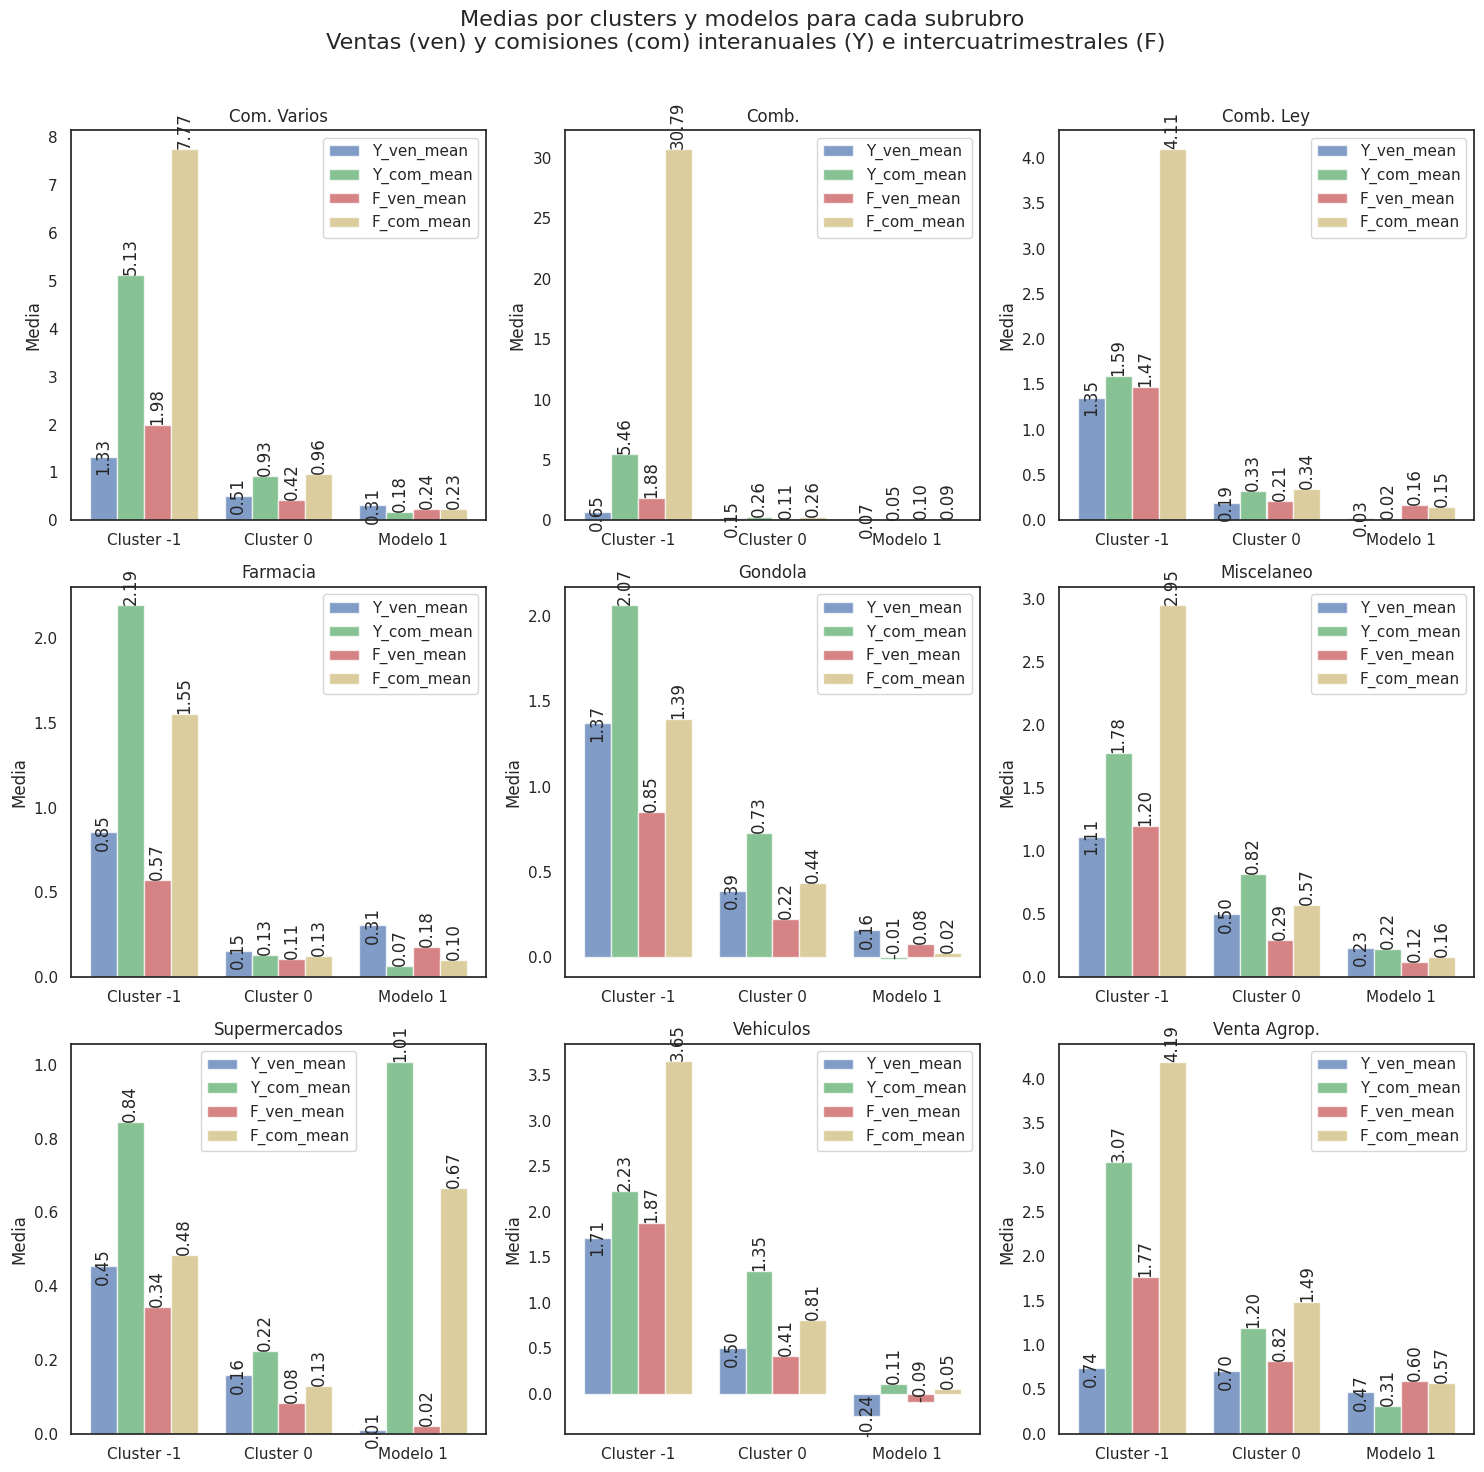

In [89]:
subrubros = final['Subrubro'].unique()

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Medias por clusters y modelos para cada subrubro\n Ventas (ven) y comisiones (com) interanuales (Y) e intercuatrimestrales (F)', fontsize=16)

for i, subrubro in enumerate(subrubros):
    row = i // 3
    col = i % 3

    media_cluster_minus_1_ven = final[(final['Cluster'] == -1) & (final['Subrubro'] == subrubro)]['Y_ven_mean'].mean()
    media_cluster_minus_1_com = final[(final['Cluster'] == -1) & (final['Subrubro'] == subrubro)]['Y_com_mean'].mean()
    media_cluster_minus_1_fen = final[(final['Cluster'] == -1) & (final['Subrubro'] == subrubro)]['F_ven_mean'].mean()
    media_cluster_minus_1_fcom = final[(final['Cluster'] == -1) & (final['Subrubro'] == subrubro)]['F_com_mean'].mean()

    media_cluster_0_ven = final[(final['Cluster'] == 0) & (final['Subrubro'] == subrubro)]['Y_ven_mean'].mean()
    media_cluster_0_com = final[(final['Cluster'] == 0) & (final['Subrubro'] == subrubro)]['Y_com_mean'].mean()
    media_cluster_0_fen = final[(final['Cluster'] == 0) & (final['Subrubro'] == subrubro)]['F_ven_mean'].mean()
    media_cluster_0_fcom = final[(final['Cluster'] == 0) & (final['Subrubro'] == subrubro)]['F_com_mean'].mean()

    media_modelo_1_ven = final[(final['Modelo'] == 1) & (final['Subrubro'] == subrubro)]['Y_ven_mean'].mean()
    media_modelo_1_com = final[(final['Modelo'] == 1) & (final['Subrubro'] == subrubro)]['Y_com_mean'].mean()
    media_modelo_1_fen = final[(final['Modelo'] == 1) & (final['Subrubro'] == subrubro)]['F_ven_mean'].mean()
    media_modelo_1_fcom = final[(final['Modelo'] == 1) & (final['Subrubro'] == subrubro)]['F_com_mean'].mean()

    grupos = ['Cluster -1', 'Cluster 0', 'Modelo 1']
    medias_ven = [media_cluster_minus_1_ven, media_cluster_0_ven, media_modelo_1_ven]
    medias_com = [media_cluster_minus_1_com, media_cluster_0_com, media_modelo_1_com]
    medias_fen = [media_cluster_minus_1_fen, media_cluster_0_fen, media_modelo_1_fen]
    medias_fcom = [media_cluster_minus_1_fcom, media_cluster_0_fcom, media_modelo_1_fcom]

    bar_width = 0.2
    index = np.arange(len(grupos))

    axes[row, col].bar(index, medias_ven, bar_width, label='Y_ven_mean', color='b', alpha=0.7)
    axes[row, col].bar(index + bar_width, medias_com, bar_width, label='Y_com_mean', color='g', alpha=0.7)
    axes[row, col].bar(index + 2 * bar_width, medias_fen, bar_width, label='F_ven_mean', color='r', alpha=0.7)
    axes[row, col].bar(index + 3 * bar_width, medias_fcom, bar_width, label='F_com_mean', color='y', alpha=0.7)

    axes[row, col].set_ylabel('Media')
    axes[row, col].set_title(f'{subrubro}')
    axes[row, col].set_xticks(index + 1.5 * bar_width)
    axes[row, col].set_xticklabels(grupos)
    axes[row, col].legend()

    for j in range(len(grupos)):
        axes[row, col].text(index[j], medias_ven[j], f'{medias_ven[j]:.2f}', ha='center', va='center', rotation = 90, transform_rotates_text = True)
        axes[row, col].text(index[j] + bar_width, medias_com[j], f'{medias_com[j]:.2f}', ha='center', va='bottom', rotation = 90, transform_rotates_text = True)
        axes[row, col].text(index[j] + 2 * bar_width, medias_fen[j], f'{medias_fen[j]:.2f}', ha='center', va='bottom', rotation = 90, transform_rotates_text = True)
        axes[row, col].text(index[j] + 3 * bar_width, medias_fcom[j], f'{medias_fcom[j]:.2f}', ha='center', va='bottom', rotation = 90, transform_rotates_text = True)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Salvo para el caso de `Supermercados`, vemos que para el resto de los subrubros, los `Modelo` son más parecidos a los vendedores del `Cluster 0`, antes que al `Cluster -1`. 

En las variables de Comisión se observa más clara la diferencia.

---
# Evaluación con variables de escala: impacto

A continuación vamos a enfocar el análisis en los vendedores que pertenecen al `Cluster -1`, para determinar qué interés tienen esos vendedores para la empresa.

En particular, vamos a segmentar al cluster en diferentes partes según los montos de Ventas que generan. Entendiendo que el interés sobre un vendedor que vende poco y está fugando no es el mismo que sobre un vendedor que vende mucho.

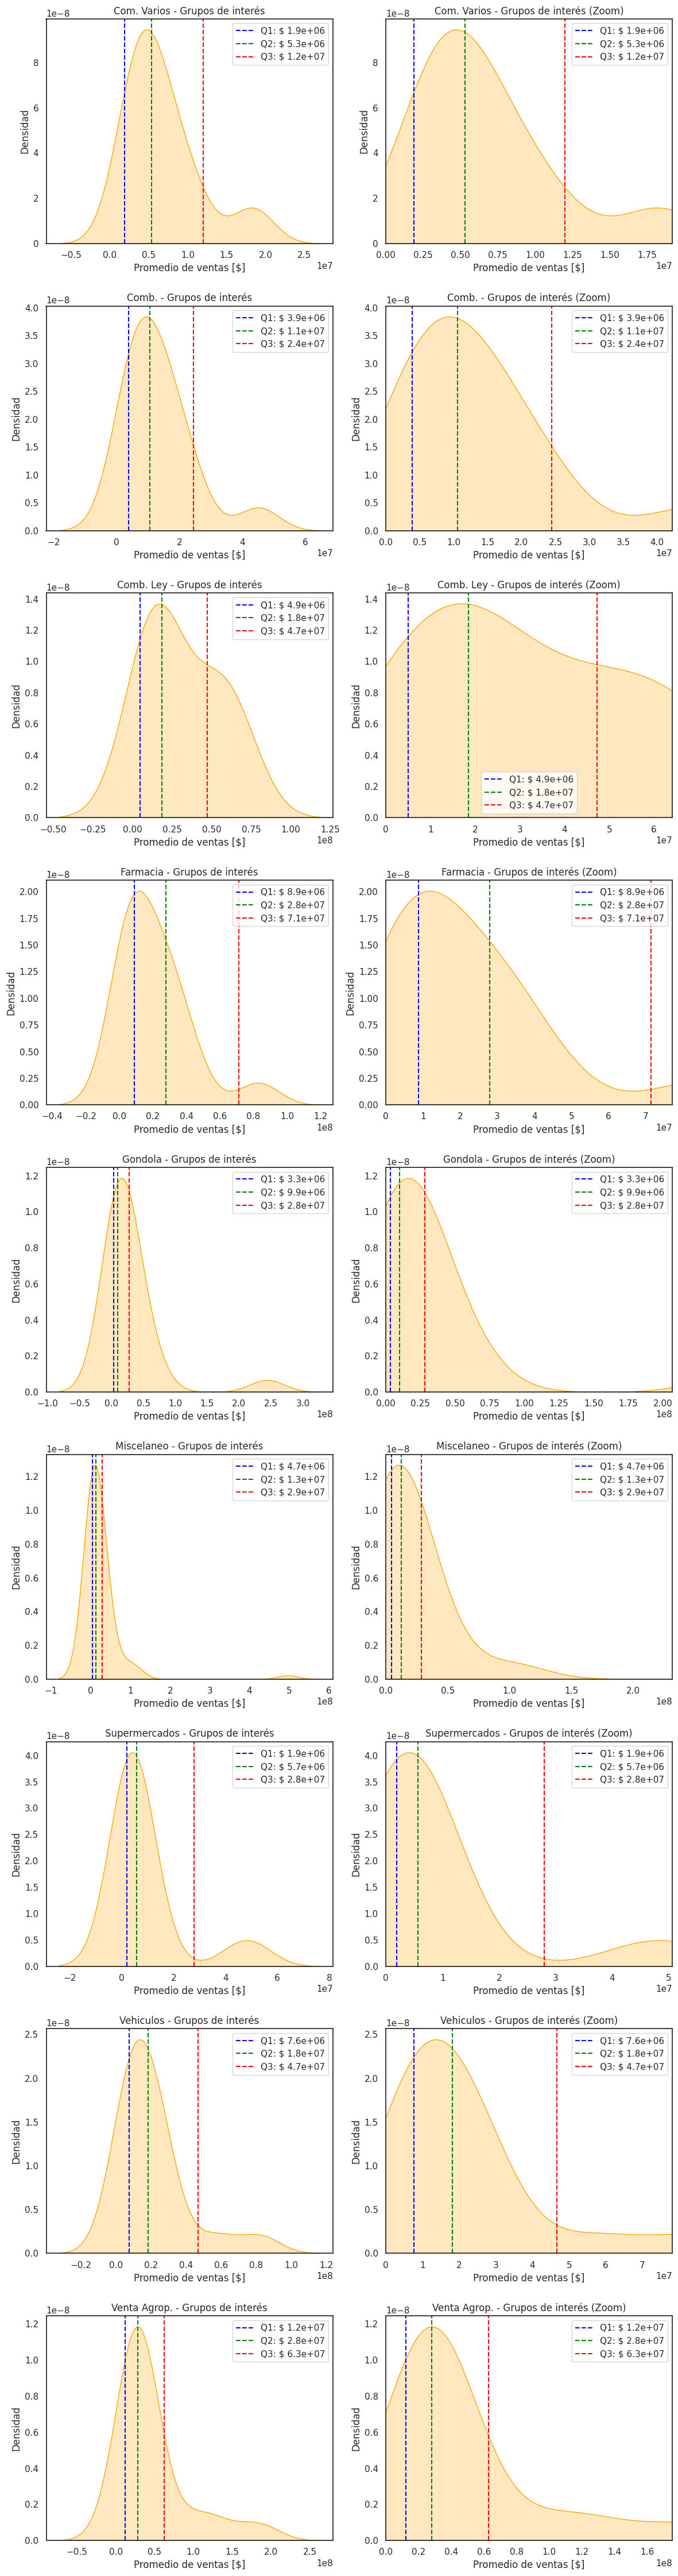

In [90]:
subrubros_unicos = final['Subrubro'].unique()
fig, axes = plt.subplots(len(subrubros_unicos), 2, figsize=(12, 5 * len(subrubros_unicos)))

for i, subrubro in enumerate(subrubros_unicos):
    df_subrubro = final[(final['Subrubro'] == subrubro) & (final['Cluster'] == -1)]

    sns.kdeplot(data=df_subrubro, x='Abs_ven_mean', fill=True, ax=axes[i, 0], color='orange')
    axes[i, 0].set_xlabel('Promedio de ventas [$]')
    axes[i, 0].set_ylabel('Densidad')
    axes[i, 0].set_title(f'{subrubro} - Grupos de interés')
    q1 = np.percentile(final[final['Subrubro'] == subrubro]['Abs_ven_mean'], 25)
    q2 = np.percentile(final[final['Subrubro'] == subrubro]['Abs_ven_mean'], 50)
    q3 = np.percentile(final[final['Subrubro'] == subrubro]['Abs_ven_mean'], 75)
    axes[i, 0].axvline(q1, color='blue', linestyle='--', label='Q1: $ {:.1e}'.format(q1))
    axes[i, 0].axvline(q2, color='green', linestyle='--', label='Q2: $ {:.1e}'.format(q2))
    axes[i, 0].axvline(q3, color='red', linestyle='--', label='Q3: $ {:.1e}'.format(q3))
    axes[i, 0].legend()

    sns.kdeplot(data=df_subrubro, x='Abs_ven_mean', fill=True, ax=axes[i, 1], color='orange')
    axes[i, 1].set_xlabel('Promedio de ventas [$]')
    axes[i, 1].set_ylabel('Densidad')
    axes[i, 1].set_title(f'{subrubro} - Grupos de interés (Zoom)')
    axes[i, 1].axvline(q1, color='blue', linestyle='--', label='Q1: $ {:.1e}'.format(q1))
    axes[i, 1].axvline(q2, color='green', linestyle='--', label='Q2: $ {:.1e}'.format(q2))
    axes[i, 1].axvline(q3, color='red', linestyle='--', label='Q3: $ {:.1e}'.format(q3))
    axes[i, 1].legend()
    axes[i, 1].set_xlim(0, df_subrubro['Abs_ven_mean'].quantile(0.99))

plt.tight_layout()
plt.show()

En este caso se graficaron las densidades de los vendedores del `Cluster -1` de cada rubro. A las cuales se les superpuso rectas verticales con el valor de los cuartiles de la distribución de todos los vendedores de ese rubro (no solo Cluster -1 sino también el Cluster 0).

El objetivo es definir 4 grupos de interés para la empresa, según su potencial impacto. Veamos en números, cuántos vendedores caen en cada grupo y qué promedio de ventas tienen:

In [91]:
pd.options.display.float_format = '{:,.0f}'.format

subrubros_unicos = final['Subrubro'].unique()

def asignar_grupo(valor, q1, q2, q3, maximo):
    if valor <= q1:
        return '1. Bajo'
    elif valor <= q2:
        return '2. Medio/Bajo'
    elif valor <= q3:
        return '3. Medio/Alto'
    else:
        return '4. Alto'

sumas_por_grupo = {}

df_cluster = final[final['Cluster'] == -1].copy()

G1tot, G2tot, G3tot, G4tot = np.empty((1,)), np.empty((1,)), np.empty((1,)), np.empty((1,))

for subrubro in subrubros_unicos:
    df_subrubro = df_cluster[df_cluster['Subrubro'] == subrubro].copy()
    
    minimo = final[final['Subrubro'] == subrubro]['Abs_ven_mean'].min()
    q1 = np.percentile(final[final['Subrubro'] == subrubro]['Abs_ven_mean'], 25)
    q2 = np.percentile(final[final['Subrubro'] == subrubro]['Abs_ven_mean'], 50)
    q3 = np.percentile(final[final['Subrubro'] == subrubro]['Abs_ven_mean'], 75)
    maximo = final[final['Subrubro'] == subrubro]['Abs_ven_mean'].max()
    
    df_subrubro.loc[:, 'Impacto'] = df_subrubro['Abs_ven_mean'].apply(lambda x: asignar_grupo(x, q1, q2, q3, maximo))
    
    estadisticas_grupo = df_subrubro.groupby('Impacto')['Abs_ven_mean'].agg(['count', 'mean', 'min', 'max']).reset_index()

    for grupo, cuenta in zip(estadisticas_grupo['Impacto'], estadisticas_grupo['count']):
        sumas_por_grupo[grupo] = sumas_por_grupo.get(grupo, 0) + cuenta

    g1 = df_subrubro[df_subrubro['Abs_ven_mean'] <= q1]['ID'].to_numpy()
    g2 = df_subrubro[(df_subrubro['Abs_ven_mean'] > q1) & (df_subrubro['Abs_ven_mean'] <= q2)]['ID'].to_numpy()
    g3 = df_subrubro[(df_subrubro['Abs_ven_mean'] > q2) & (df_subrubro['Abs_ven_mean'] <= q3)]['ID'].to_numpy()
    g4 = df_subrubro[df_subrubro['Abs_ven_mean'] >= q3]['ID'].to_numpy()
    Gsr = pd.DataFrame([g1, g2, g3, g4], index =['1. Bajo', '2. Medio/Bajo', '3. Medio/Alto', '4. Alto'], dtype=str)
    Gsr.fillna('---', inplace=True)

    G1tot = np.concatenate((G1tot, g1))
    G2tot = np.concatenate((G2tot, g2))
    G3tot = np.concatenate((G3tot, g3))
    G4tot = np.concatenate((G4tot, g4))

    print(f'\n\n\n\n{subrubro}')
    display(estadisticas_grupo)
    print('\t>>> ID de vendedores según impacto:')
    display(Gsr)

print("Total")
sumas_por_grupo_df = pd.DataFrame(list(sumas_por_grupo.items()), columns=['Impacto', 'Count'])
display(sumas_por_grupo_df)





Com. Varios


,Impacto,count,mean,min,max
0,1. Bajo,2,"1,119,361","913,802","1,324,920"
1,2. Medio/Bajo,12,"3,719,859","2,467,560","5,323,900"
2,3. Medio/Alto,11,"7,668,400","5,358,171","10,613,783"
3,4. Alto,4,"16,783,207","12,066,707","19,542,226"


	>>> ID de vendedores según impacto:


,0,1,2,3,4,5,6,7,8,9,10,11
1. Bajo,1357,1500,---,---,---,---,---,---,---,---,---,---
2. Medio/Bajo,141,735,1245.0,1286.0,1344.0,1456.0,1462.0,1582.0,1897.0,2802.0,2900.0,2946.0
3. Medio/Alto,233,324,1131.0,1304.0,1333.0,1527.0,1736.0,2078.0,2170.0,2455.0,2696.0,---
4. Alto,373,1417,2166.0,2341.0,---,---,---,---,---,---,---,---






Comb.


,Impacto,count,mean,min,max
0,1. Bajo,3,"2,703,231","1,169,725","3,880,323"
1,2. Medio/Bajo,4,"7,253,081","4,694,252","8,159,362"
2,3. Medio/Alto,7,"16,850,347","12,255,317","24,484,554"
3,4. Alto,1,"45,114,383","45,114,383","45,114,383"


	>>> ID de vendedores según impacto:


,0,1,2,3,4,5,6
1. Bajo,1320,1757,2850.0,---,---,---,---
2. Medio/Bajo,79,114,283.0,468.0,---,---,---
3. Medio/Alto,171,233,380.0,438.0,876.0,1775.0,2902.0
4. Alto,171,1028,---,---,---,---,---






Comb. Ley


,Impacto,count,mean,min,max
0,2. Medio/Bajo,3,"14,171,775","7,276,312","17,938,704"
1,4. Alto,2,"57,509,271","50,334,150","64,684,392"


	>>> ID de vendedores según impacto:


,0,1,2
1. Bajo,---,---,---
2. Medio/Bajo,1719.0,2177.0,2383.0
3. Medio/Alto,---,---,---
4. Alto,380.0,1206.0,---






Farmacia


,Impacto,count,mean,min,max
0,1. Bajo,6,"4,314,910","621,176","7,024,120"
1,2. Medio/Bajo,5,"17,340,730","8,873,968","24,044,319"
2,3. Medio/Alto,4,"35,807,951","31,978,659","43,706,594"
3,4. Alto,1,"83,059,320","83,059,320","83,059,320"


	>>> ID de vendedores según impacto:


,0,1,2,3,4,5
1. Bajo,313,978.0,1646.0,1659.0,1734.0,2290.0
2. Medio/Bajo,1201,1360.0,2123.0,2162.0,2211.0,---
3. Medio/Alto,1128,2074.0,2334.0,2338.0,---,---
4. Alto,2089,---,---,---,---,---






Gondola


,Impacto,count,mean,min,max
0,1. Bajo,3,"1,250,479","603,850","1,986,838"
1,2. Medio/Bajo,6,"7,105,232","3,817,592","9,931,648"
2,3. Medio/Alto,7,"19,805,030","12,395,668","26,584,889"
3,4. Alto,6,"78,155,190","30,790,066","244,076,099"


	>>> ID de vendedores según impacto:


,0,1,2,3,4,5,6
1. Bajo,163,2175,2359,---,---,---,---
2. Medio/Bajo,80,205,921,2619.0,2715.0,2825.0,---
3. Medio/Alto,112,313,1220,1251.0,1744.0,2343.0,2925.0
4. Alto,148,527,1216,1591.0,2428.0,2860.0,---






Miscelaneo


,Impacto,count,mean,min,max
0,1. Bajo,22,"2,716,621","501,344","4,696,212"
1,2. Medio/Bajo,22,"8,408,272","4,969,853","12,292,372"
2,3. Medio/Alto,12,"19,202,058","12,686,716","26,658,213"
3,4. Alto,14,"90,168,191","29,169,305","497,270,813"


	>>> ID de vendedores según impacto:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
1. Bajo,358,380,485,732,1055,1173,1390,1437,1594,1725,1990,1996,2196.0,2357.0,2562.0,2568.0,2621.0,2662.0,2845.0,2850.0,2946.0,2951.0
2. Medio/Bajo,307,493,538,660,811,1030,1040,1077,1116,1307,1343,1351,1355.0,1436.0,1521.0,1921.0,1925.0,1948.0,2326.0,2367.0,2546.0,2919.0
3. Medio/Alto,39,218,324,1334,1372,1632,1879,1995,2105,2115,2600,2966,---,---,---,---,---,---,---,---,---,---
4. Alto,616,814,1174,1353,1423,1575,1930,1967,2019,2377,2729,2742,2855.0,2902.0,---,---,---,---,---,---,---,---






Supermercados


,Impacto,count,mean,min,max
0,1. Bajo,5,"1,431,653","418,493","1,851,904"
1,2. Medio/Bajo,6,"3,569,306","1,928,595","5,582,682"
2,3. Medio/Alto,5,"8,028,481","5,712,829","11,111,367"
3,4. Alto,2,"48,231,012","44,638,001","51,824,023"


	>>> ID de vendedores según impacto:


,0,1,2,3,4,5
1. Bajo,97,382,1021.0,1452.0,1853.0,---
2. Medio/Bajo,1720,1755,2116.0,2167.0,2843.0,2885.0
3. Medio/Alto,171,370,793.0,2643.0,2744.0,---
4. Alto,2137,2409,---,---,---,---






Vehiculos


,Impacto,count,mean,min,max
0,1. Bajo,5,"4,962,998","1,474,743","7,609,678"
1,2. Medio/Bajo,5,"12,421,057","10,408,441","14,916,997"
2,3. Medio/Alto,6,"24,216,345","19,591,958","30,581,673"
3,4. Alto,2,"69,976,858","57,577,507","82,376,209"


	>>> ID de vendedores según impacto:


,0,1,2,3,4,5
1. Bajo,229,791,1396.0,2581.0,2857.0,---
2. Medio/Bajo,136,523,1145.0,1166.0,2790.0,---
3. Medio/Alto,1356,1477,2159.0,2309.0,2674.0,2924.0
4. Alto,1504,2467,---,---,---,---






Venta Agrop.


,Impacto,count,mean,min,max
0,1. Bajo,1,"5,950,751","5,950,751","5,950,751"
1,2. Medio/Bajo,7,"24,407,065","14,741,724","27,495,378"
2,3. Medio/Alto,6,"35,326,548","28,796,427","46,063,257"
3,4. Alto,3,"136,382,817","96,491,744","184,130,962"


	>>> ID de vendedores según impacto:


,0,1,2,3,4,5,6
1. Bajo,1141,---,---,---,---,---,---
2. Medio/Bajo,876,1236.0,1399.0,1442.0,1579.0,1630.0,1902.0
3. Medio/Alto,970,1208.0,1242.0,2078.0,2147.0,2605.0,---
4. Alto,2661,2716.0,2782.0,---,---,---,---


Total


,Impacto,Count
0,1. Bajo,47
1,2. Medio/Bajo,70
2,3. Medio/Alto,58
3,4. Alto,35


En consecuencia, habrá: 
* 47 vendedores que por lo poco que venden, probablemente no sean de interés (se ubican debajo del cuartil 1 de su subrubro, considerando vendedores de todos los clusters).
* 70 + 58 = 128 vendedores que por lo que venden, probablemente sean de interés medio (entre el cuartil 1 y 3 de su subrubro).
* 35 vendedores que por lo mucho que venden, problablemente sean de interés alto (se ubican por encima del cuartil 3 del subrubro).